In [1]:
# mostly pulled from hls4ml_3.ipynb and waveform_demo.ipynb
# last updated 2025-05-05 by mza
name = "mza_try5"
num_epochs = 10000
batch_size = 1000
hidden_nodes = [ 64 ]
hidden_node_type = "relu"
truths_to_use = [ 2 ] # t_peak, t_sigma, height, pedestal
use_pruning = False
prune_ratio = 0.1
train = True
synth_hls = True
integer_part = 1
input_quantization = 9
inner_quantization = 9
output_quantization = 10

In [2]:
import os, errno
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['PATH'] = os.environ['XILINX_VIVADO'] + '/bin:' + os.environ['PATH']
import numpy as np
seed = 0
np.random.seed(seed)
import matplotlib.pyplot as plt
try:
    os.mkdir(name)
except OSError as exception:
    if exception.errno != errno.EEXIST:
        raise

In [3]:
dataset1 = np.load('waveform_data_0.npy') # (10000, 104)
dataset2 = np.load('waveform_data_1.npy') # (10000, 104)
dataset = np.concatenate((dataset1, dataset2))
num_waveforms = len(dataset)
training_quantity = int(0.8 * num_waveforms)
num_truths = 4
time_samples = len(dataset[0]) - num_truths
print("num_waveforms: " + str(num_waveforms))
num_truths_to_use = len(truths_to_use)
print("num_truths_to_use: " + str(num_truths_to_use))
waveforms = dataset[:,num_truths:]
truths = dataset[:,:num_truths]
waveform_min = min([ min(waveforms[i]) for i in range(len(waveforms)) ])
waveform_max = max([ max(waveforms[i]) for i in range(len(waveforms)) ])
offset = waveform_min
gain = 1.0 / (waveform_max - waveform_min)
scaled_waveforms = np.array([ [ gain * (waveforms[j,i] - offset) for i in range(time_samples) ] for j in range(num_waveforms) ])
scaled_truths = np.array([ [ truths[j,0]/time_samples, truths[j,1]/time_samples, gain * (truths[j,2] - offset), gain * (truths[j,3] - offset) ] for j in range(num_waveforms) ])
train_data = scaled_waveforms[:training_quantity,:]
print("train_data.shape: " + str(train_data.shape))
train_truth = scaled_truths[:training_quantity,truths_to_use]
print("train_truth.shape: " + str(train_truth.shape))
test_data = scaled_waveforms[training_quantity:,:]
print("test_data.shape: " + str(test_data.shape))
test_truth = scaled_truths[training_quantity:,truths_to_use]
print("test_truth.shape: " + str(test_truth.shape))

num_waveforms: 20000
num_truths_to_use: 1
train_data.shape: (16000, 100)
train_truth.shape: (16000, 1)
test_data.shape: (4000, 100)
test_truth.shape: (4000, 1)


In [4]:
evt = 8
if 0:
    x = np.zeros(time_samples)
    for i in range(time_samples):
        x[i] = i/time_samples
    y = train_data[evt]
    plt.xlim(0, 1), plt.ylim(0, 1)
    plt.scatter(x, y)
    plt.plot([train_truth[evt][0], train_truth[evt][0]], [0.0, 1.0], color="green")
    plt.show()

In [5]:
print("time position of the peak: ", train_truth[evt][0]) # The 0th column: mean of the Gaussian peak

time position of the peak:  0.464568000830314


In [6]:
import tensorflow as tf
tf.random.set_seed(seed)
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l1
from tensorflow.keras.layers import Activation
from tensorflow.keras import optimizers
from callbacks import all_callbacks
from qkeras.qlayers import QDense, QActivation
from qkeras.quantizers import quantized_bits, quantized_relu, quantized_sigmoid

In [7]:
input_quantizer = quantized_bits(input_quantization, integer_part, alpha=1)
inner_quantizer = quantized_bits(inner_quantization, integer_part, alpha=1)
output_quantizer = quantized_bits(output_quantization, integer_part, alpha=1)
output_quantization_string = 'ap_fixed<' + str(output_quantization) + ',' + str(integer_part) + '>'
if hidden_node_type=="relu":
    hidden_activations = [ quantized_relu(inner_quantization) for i in range(len(hidden_nodes)) ]
else:
    hidden_activations = [ quantized_sigmoid(inner_quantization) for i in range(len(hidden_nodes)) ]
hidden_names = [ hidden_node_type for i in range(len(hidden_nodes)) ]
model = Sequential()
model.add(QDense(time_samples, input_shape=(time_samples,), name='input_qdense', kernel_quantizer=input_quantizer, bias_quantizer=input_quantizer, kernel_initializer='glorot_uniform'))
model.add(QActivation(activation=quantized_sigmoid(input_quantization), name='input_sigmoid'))
for i in range(len(hidden_nodes)):
    model.add(QDense(hidden_nodes[i], name=hidden_names[i] + str(i) + "qdense", kernel_quantizer=inner_quantizer, bias_quantizer=inner_quantizer, kernel_initializer='glorot_uniform'))
    model.add(QActivation(activation=hidden_activations[i], name=hidden_names[i] + str(i) + "activation"))
model.add(QDense(num_truths_to_use, name='output_qdense', kernel_quantizer=output_quantizer, bias_quantizer=output_quantizer, kernel_initializer='glorot_uniform'))
if num_truths_to_use<2:
    model.add(Activation(activation='sigmoid', name='output_sigmoid'))
else:
    model.add(Activation(activation='softmax', name='output_softmax'))

In [8]:
if use_pruning:
    from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_callbacks, pruning_schedule
    from tensorflow_model_optimization.sparsity.keras import strip_pruning
    # the first argument is the percentage of the weights that will be forced to be 0
    pruning_params = {"pruning_schedule": pruning_schedule.ConstantSparsity(prune_ratio, begin_step=2000, frequency=100)}
    model = prune.prune_low_magnitude(model, **pruning_params)

In [9]:
if train:
    #optimizer = optimizers.Adam(learning_rate=0.0001)
    optimizer = optimizers.SGD(learning_rate=0.1)
    #model.compile(optimizer=optimizer, loss=['categorical_crossentropy'], metrics=['accuracy'])
    model.compile(optimizer=optimizer, loss=['mse'])
    if use_pruning:
        callbacks = all_callbacks(stop_patience=1000, lr_factor=0.5, lr_patience=10, lr_epsilon=0.000001, lr_cooldown=2, lr_minimum=0.0000001, outputDir=name)
        callbacks.callbacks.append(pruning_callbacks.UpdatePruningStep())
        model.fit(train_data, train_truth, batch_size=batch_size, epochs=num_epochs, validation_split=0.25, shuffle=False, callbacks=callbacks.callbacks, verbose=0)
    else:
        model.fit(train_data, train_truth, batch_size=batch_size, epochs=num_epochs, validation_split=0.25, shuffle=False, verbose=0)
    #loss, acc = model.evaluate(test_data, test_truth, verbose=0)
    if use_pruning:
        model = strip_pruning(model)
    model.save(name + '/KERAS_check_best_model.keras')
else:
    from tensorflow.keras.models import load_model
    from qkeras.utils import _add_supported_quantized_objects
    co = {}
    _add_supported_quantized_objects(co)
    model = load_model(name + '/KERAS_check_best_model.keras', custom_objects=co) # TypeError: <qkeras.qlayers.QActivation object at 0x774300567100> could not be deserialized properly. Please ensure that components that are Python object instances (layers, models, etc.) returned by `get_config()` are explicitly deserialized in the model's `from_config()` method.

/root/anaconda3/envs/hls4ml-tutorial/lib/python3.10/site-packages/keras/src/constraints.py:365: UserWarning: The `keras.constraints.serialize()` API should only be used for objects of type `keras.constraints.Constraint`. Found an instance of type <class 'qkeras.quantizers.quantized_bits'>, which may lead to improper serialization.
  warnings.warn(


In [10]:
#print('test_acc: {:.3f}, test_loss: {:.3f}'.format(acc, loss))
train_prediction = model.predict(train_data)
test_prediction = model.predict(test_data)

125/125 [==============================] - 0s 918us/step


In [11]:
evt = 5
if 0:
    print(str(test_prediction[evt]) + " : " + str(test_truth[evt]))
    x = np.zeros(time_samples)
    for i in range(time_samples):
        x[i] = i/time_samples
    y = test_data[evt]
    plt.xlim(0, 1); plt.ylim(0, 1)
    plt.scatter(x, y, color="blue")
    plt.plot([test_prediction[evt,0], test_prediction[evt,0]], [0.0, 1.0], color="red")
    plt.plot([test_truth[evt,0], test_truth[evt,0]], [0.0, 1.0], color="green")
    plt.show()

In [12]:
import csv
with open(name + '/Input.dat', 'w') as f:
    csv.writer(f, delimiter=' ').writerows(test_data)
with open(name + '/Output.dat', 'w') as f:
    csv.writer(f, delimiter=' ').writerows(test_prediction)

In [13]:
import hls4ml, plotting
config = hls4ml.utils.config_from_keras_model(model, granularity='name', default_reuse_factor=10)
config['LayerName']['output_sigmoid']['exp_table_t'] = output_quantization_string
config['LayerName']['output_sigmoid']['inv_table_t'] = output_quantization_string
config['LayerName']['output_sigmoid']['Precision']   = output_quantization_string
plotting.print_dict(config)
hls_model = hls4ml.converters.convert_from_keras_model(
    model, hls_config=config, output_dir=name + '/hls4ml_prj', part='xc7z020clg400-1',
    input_data_tb = name + "/Input.dat", output_data_tb = name + "/Output.dat", backend='Vitis', verbose=0
)

Interpreting Sequential
Topology:
Layer name: input_qdense_input, layer type: InputLayer, input shapes: [[None, 100]], output shape: [None, 100]
Layer name: input_qdense, layer type: QDense, input shapes: [[None, 100]], output shape: [None, 100]
Layer name: input_sigmoid, layer type: HardActivation, input shapes: [[None, 100]], output shape: [None, 100]
Layer name: relu0qdense, layer type: QDense, input shapes: [[None, 100]], output shape: [None, 64]
Layer name: relu0activation, layer type: Activation, input shapes: [[None, 64]], output shape: [None, 64]
Layer name: output_qdense, layer type: QDense, input shapes: [[None, 64]], output shape: [None, 1]
Layer name: output_sigmoid, layer type: Activation, input shapes: [[None, 1]], output shape: [None, 1]
Model
  Precision
    default:         fixed<16,6>
  ReuseFactor:       10
  Strategy:          Latency
  BramFactor:        1000000000
  TraceOutput:       False
LayerName
  input_qdense_input
    Trace:           False
    Precision
  

/root/anaconda3/envs/hls4ml-tutorial/lib/python3.10/site-packages/keras/src/constraints.py:365: UserWarning: The `keras.constraints.serialize()` API should only be used for objects of type `keras.constraints.Constraint`. Found an instance of type <class 'qkeras.quantizers.quantized_bits'>, which may lead to improper serialization.
  warnings.warn(


In [14]:
from IPython.display import Image
hls4ml.utils.plot_model(hls_model, show_shapes=True, show_precision=True, to_file=name + '/hls_model.png')
#Image(name + '/hls_model.png')

In [15]:
hls_model.compile()

/root/anaconda3/envs/hls4ml-tutorial/lib/python3.10/site-packages/keras/src/constraints.py:365: UserWarning: The `keras.constraints.serialize()` API should only be used for objects of type `keras.constraints.Constraint`. Found an instance of type <class 'qkeras.quantizers.quantized_bits'>, which may lead to improper serialization.
  warnings.warn(


Writing HLS project
Done


In [16]:
hls_train_prediction = hls_model.predict(np.ascontiguousarray(train_data))
hls_test_prediction = hls_model.predict(np.ascontiguousarray(test_data))

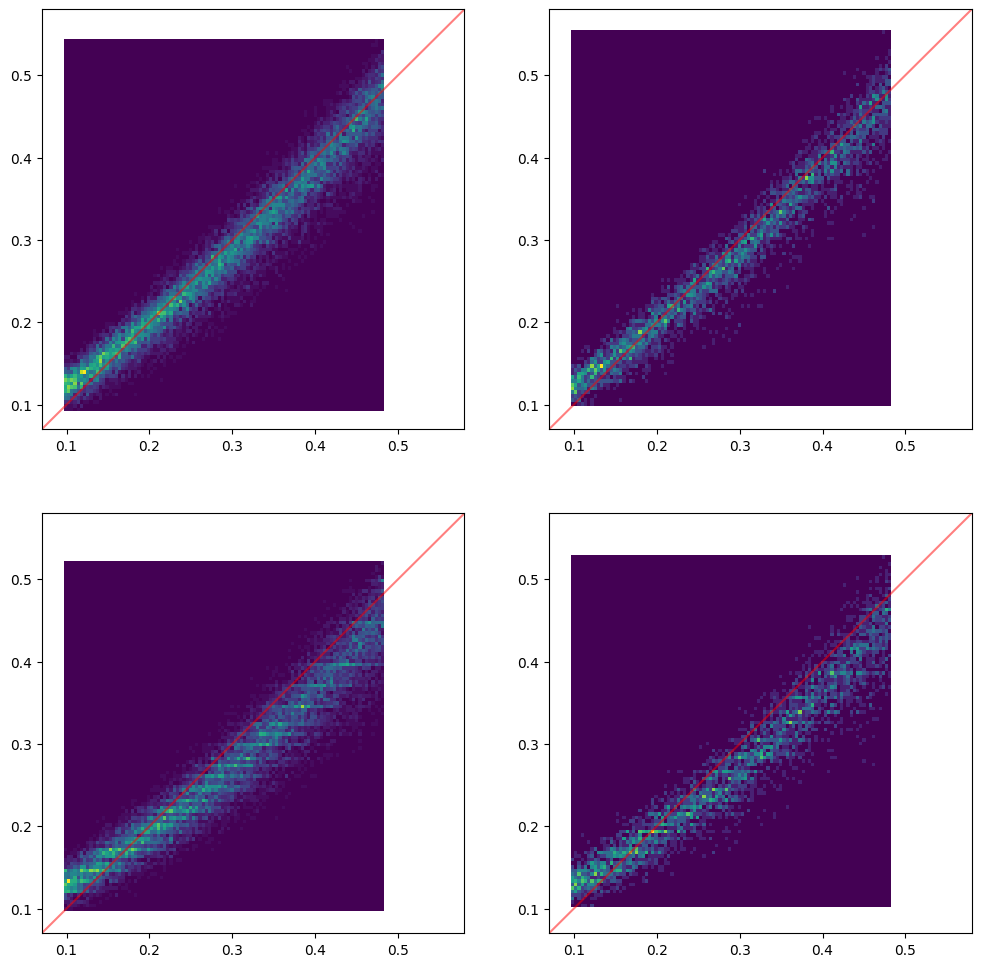

In [17]:
nbins = 100
a = 0.07; b = 0.58
for i in range(num_truths_to_use):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(12,12))
    ax1.hist2d(train_truth[:,i].ravel(), train_prediction[:,i].ravel(),     bins=nbins); ax1.plot([0.0, 1.0], [0.0, 1.0], color="red", alpha=0.5); ax1.set_xlim(a, b); ax1.set_ylim(a, b)
    ax2.hist2d(test_truth[:,i].ravel(),  test_prediction[:,i].ravel(),      bins=nbins); ax2.plot([0.0, 1.0], [0.0, 1.0], color="red", alpha=0.5); ax2.set_xlim(a, b); ax2.set_ylim(a, b)
    ax3.hist2d(train_truth[:,i].ravel(), hls_train_prediction[:,i].ravel(), bins=nbins); ax3.plot([0.0, 1.0], [0.0, 1.0], color="red", alpha=0.5); ax3.set_xlim(a, b); ax3.set_ylim(a, b)
    ax4.hist2d(test_truth[:,i].ravel(),  hls_test_prediction[:,i].ravel(),  bins=nbins); ax4.plot([0.0, 1.0], [0.0, 1.0], color="red", alpha=0.5); ax4.set_xlim(a, b); ax4.set_ylim(a, b)
    plt.show()
    fig.savefig(name + "/hist2d." + str(truths_to_use[i]) + ".png")

In [18]:
if synth_hls:
    hls_model.build(synth=True, csim=True, cosim=True)


****** Vitis HLS - High-Level Synthesis from C, C++ and OpenCL v2023.1 (64-bit)
  **** SW Build 3854077 on May  4 2023
  **** IP Build 3864474 on Sun May  7 20:36:21 MDT 2023
  **** SharedData Build 3865790 on Sun May 07 13:33:03 MDT 2023
    ** Copyright 1986-2022 Xilinx, Inc. All Rights Reserved.
    ** Copyright 2022-2023 Advanced Micro Devices, Inc. All Rights Reserved.

source /opt/Xilinx/Vitis_HLS/2023.1/scripts/vitis_hls/hls.tcl -notrace
INFO: [HLS 200-10] Running '/opt/Xilinx/Vitis_HLS/2023.1/bin/unwrapped/lnx64.o/vitis_hls'
INFO: [HLS 200-10] For user 'root' on host '17425374c219' (Linux_x86_64 version 6.11.0-21-generic) on Tue May 06 13:02:40 EDT 2025
INFO: [HLS 200-10] In directory '/root/build/phys476/final_project/waveform_dataset/mza_try5/hls4ml_prj'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-1510] Running: open_project myproject_prj 
INFO: [HLS 200-10] Opening project '/root/build/phys476/final_project/waveform_dataset/mza_try5/hls4ml_prj/myproject_prj'.
INFO: [

INFO: [HLS 214-131] Inlining function 'nnet::product::mult<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<9, 2, (ap_q_mode)5, (ap_o_mode)3, 0> >::product(ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<9, 2, (ap_q_mode)5, (ap_o_mode)3, 0>)' into 'void nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<33, 16, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>(ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>*, ap_fixed<33, 16, (ap_q_mode)5, (ap_o_mode)3, 0>*, config2::weight_t*, config2::bias_t*)' (firmware/nnet_utils/nnet_dense_latency.h:42:27)
INFO: [HLS 214-131] Inlining function 'nnet::DenseLatency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<33, 16, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>::dense(ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>*, ap_fixed<33, 16, (ap_q_mode)5, (ap_o_mode)3, 0>*, ap_fixed<9, 2, (ap_q_mode)5, (ap_o_mode)3, 0>*, ap_fixed<9, 2, (ap_q_mode)5, (ap_o_mode)3, 0>*)' into 'void nnet::dense<ap_fixed<16, 6, (ap_q_mode

INFO: [HLS 200-111] Finished Standard Transforms: CPU user time: 2.06 seconds. CPU system time: 0.05 seconds. Elapsed time: 2.14 seconds; current allocated memory: 1.199 GB.
INFO: [HLS 200-10] Checking synthesizability ...
INFO: [HLS 200-111] Finished Checking Synthesizability: CPU user time: 1.84 seconds. CPU system time: 0 seconds. Elapsed time: 1.85 seconds; current allocated memory: 1.199 GB.
INFO: [XFORM 203-602] Inlining function 'nnet::cast<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<33, 16, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>' into 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<33, 16, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>' (firmware/nnet_utils/nnet_dense_latency.h:66) automatically.
INFO: [XFORM 203-602] Inlining function 'nnet::cast<ap_ufixed<9, 0, (ap_q_mode)4, (ap_o_mode)0, 0>, ap_fixed<26, 10, (ap_q_mode)5, (ap_o_mode)3, 0>, config5>' into 'nnet::dense_latency<ap_ufixed<9, 0, (ap_q_mode)4, (ap_o_mode)0, 0>, ap_fixed<26, 1

INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'relu_ap_fixed_26_10_5_3_0_ap_ufixed_9_0_4_0_0_relu_config7_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SCHED 204-61] Pipelining function 'relu<ap_fixed<26, 10, 5, 3, 0>, ap_ufixed<9, 0, 4, 0, 0>, relu_config7>'.
INFO: [HLS 200-1470] Pipelining result : Target II = NA, Final II = 1, Depth = 2, function 'relu<ap_fixed<26, 10, 5, 3, 0>, ap_ufixed<9, 0, 4, 0, 0>, relu_config7>'
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111] Finished Scheduling: CPU user time: 3.66 seconds. CPU system time: 0.06 seconds. Elapsed time: 3.77 seconds; current allocated memory: 2.191 GB.
INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101]

INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'relu_ap_fixed_26_10_5_3_0_ap_ufixed_9_0_4_0_0_relu_config7_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'relu_ap_fixed_26_10_5_3_0_ap_ufixed_9_0_4_0_0_relu_config7_s'.
INFO: [HLS 200-111] Finished Creating RTL model: CPU user time: 42.76 seconds. CPU system time: 0.65 seconds. Elapsed time: 43.49 seconds; current allocated memory: 3.539 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'dense_latency_ap_ufixed_9_0_4_0_0_ap_fixed_26_9_5_3_0_config8_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-1030] Apply Unified Pipeline Control on module 'dense_latency_ap_ufixed_9_0_4_0_0_ap_fixed_26_9_5_3_0_config8_s' pipeline 'dense_

INFO: [VRFC 10-2263] Analyzing SystemVerilog file "/root/build/phys476/final_project/waveform_dataset/mza_try5/hls4ml_prj/myproject_prj/solution1/sim/verilog/myproject_dense_latency_ap_ufixed_9_0_4_0_0_ap_fixed_26_9_5_3_0_config8_s.v" into library xil_defaultlib
INFO: [VRFC 10-311] analyzing module myproject_dense_latency_ap_ufixed_9_0_4_0_0_ap_fixed_26_9_5_3_0_config8_s
INFO: [VRFC 10-2263] Analyzing SystemVerilog file "/root/build/phys476/final_project/waveform_dataset/mza_try5/hls4ml_prj/myproject_prj/solution1/sim/verilog/myproject_sigmoid_ap_fixed_26_9_5_3_0_ap_fixed_10_1_5_3_0_sigmoid_config10_s_sigmoid_tabkb.v" into library xil_defaultlib
INFO: [VRFC 10-311] analyzing module myproject_sigmoid_ap_fixed_26_9_5_3_0_ap_fixed_10_1_5_3_0_sigmoid_config10_s_sigmoid_tabkb
INFO: [VRFC 10-2263] Analyzing SystemVerilog file "/root/build/phys476/final_project/waveform_dataset/mza_try5/hls4ml_prj/myproject_prj/solution1/sim/verilog/myproject_mul_16s_5ns_21_2_0.v" into library xil_defaultlib


Starting static elaboration
Pass Through NonSizing Optimizer
Completed static elaboration
Starting simulation data flow analysis
Completed simulation data flow analysis
Time Resolution for simulation is 1ps
Compiling package xil_defaultlib.$unit_dataflow_monitor_sv
Compiling module xil_defaultlib.myproject_mul_16s_6ns_22_2_1(NUM...
Compiling module xil_defaultlib.myproject_mul_16s_5ns_21_2_1(NUM...
Compiling module xil_defaultlib.myproject_mul_16s_5s_21_2_1(NUM_...
Compiling module xil_defaultlib.myproject_mul_16s_6s_22_2_1(NUM_...
Compiling module xil_defaultlib.myproject_mul_16s_7s_23_2_1(NUM_...
Compiling module xil_defaultlib.myproject_mul_16s_7ns_23_2_1(NUM...
Compiling module xil_defaultlib.myproject_dense_latency_ap_fixed...
Compiling module xil_defaultlib.myproject_hard_sigmoid_ap_fixed_...
Compiling module xil_defaultlib.myproject_mul_9ns_6s_15_3_1(NUM_...
Compiling module xil_defaultlib.myproject_mul_9ns_6ns_14_3_1(NUM...
Compiling module xil_defaultlib.myproject_mul_9ns_7ns_

// RTL Simulation : 19 / 4000 [77.27%] @ "1243000"
// RTL Simulation : 20 / 4000 [77.27%] @ "1293000"
// RTL Simulation : 21 / 4000 [77.27%] @ "1343000"
// RTL Simulation : 22 / 4000 [77.27%] @ "1393000"
// RTL Simulation : 23 / 4000 [77.27%] @ "1443000"
// RTL Simulation : 24 / 4000 [77.27%] @ "1493000"
// RTL Simulation : 25 / 4000 [77.27%] @ "1543000"
// RTL Simulation : 26 / 4000 [77.27%] @ "1593000"
// RTL Simulation : 27 / 4000 [77.27%] @ "1643000"
// RTL Simulation : 28 / 4000 [77.27%] @ "1693000"
// RTL Simulation : 29 / 4000 [77.27%] @ "1743000"
// RTL Simulation : 30 / 4000 [77.27%] @ "1793000"
// RTL Simulation : 31 / 4000 [77.27%] @ "1843000"
// RTL Simulation : 32 / 4000 [77.27%] @ "1893000"
// RTL Simulation : 33 / 4000 [77.27%] @ "1943000"
// RTL Simulation : 34 / 4000 [77.27%] @ "1993000"
// RTL Simulation : 35 / 4000 [77.27%] @ "2043000"
// RTL Simulation : 36 / 4000 [77.27%] @ "2093000"
// RTL Simulation : 37 / 4000 [77.27%] @ "2143000"
// RTL Simulation : 38 / 4000 [

// RTL Simulation : 187 / 4000 [77.27%] @ "9643000"
// RTL Simulation : 188 / 4000 [77.27%] @ "9693000"
// RTL Simulation : 189 / 4000 [77.27%] @ "9743000"
// RTL Simulation : 190 / 4000 [77.27%] @ "9793000"
// RTL Simulation : 191 / 4000 [77.27%] @ "9843000"
// RTL Simulation : 192 / 4000 [77.27%] @ "9893000"
// RTL Simulation : 193 / 4000 [77.27%] @ "9943000"
// RTL Simulation : 194 / 4000 [77.27%] @ "9993000"
// RTL Simulation : 195 / 4000 [77.27%] @ "10043000"
// RTL Simulation : 196 / 4000 [77.27%] @ "10093000"
// RTL Simulation : 197 / 4000 [77.27%] @ "10143000"
// RTL Simulation : 198 / 4000 [77.27%] @ "10193000"
// RTL Simulation : 199 / 4000 [77.27%] @ "10243000"
// RTL Simulation : 200 / 4000 [77.27%] @ "10293000"
// RTL Simulation : 201 / 4000 [77.27%] @ "10343000"
// RTL Simulation : 202 / 4000 [77.27%] @ "10393000"
// RTL Simulation : 203 / 4000 [77.27%] @ "10443000"
// RTL Simulation : 204 / 4000 [77.27%] @ "10493000"
// RTL Simulation : 205 / 4000 [77.27%] @ "10543000"
/

// RTL Simulation : 343 / 4000 [77.27%] @ "17443000"
// RTL Simulation : 344 / 4000 [77.27%] @ "17493000"
// RTL Simulation : 345 / 4000 [77.27%] @ "17543000"
// RTL Simulation : 346 / 4000 [77.27%] @ "17593000"
// RTL Simulation : 347 / 4000 [77.27%] @ "17643000"
// RTL Simulation : 348 / 4000 [77.27%] @ "17693000"
// RTL Simulation : 349 / 4000 [77.27%] @ "17743000"
// RTL Simulation : 350 / 4000 [77.27%] @ "17793000"
// RTL Simulation : 351 / 4000 [77.27%] @ "17843000"
// RTL Simulation : 352 / 4000 [77.27%] @ "17893000"
// RTL Simulation : 353 / 4000 [77.27%] @ "17943000"
// RTL Simulation : 354 / 4000 [77.27%] @ "17993000"
// RTL Simulation : 355 / 4000 [77.27%] @ "18043000"
// RTL Simulation : 356 / 4000 [77.27%] @ "18093000"
// RTL Simulation : 357 / 4000 [77.27%] @ "18143000"
// RTL Simulation : 358 / 4000 [77.27%] @ "18193000"
// RTL Simulation : 359 / 4000 [77.27%] @ "18243000"
// RTL Simulation : 360 / 4000 [77.27%] @ "18293000"
// RTL Simulation : 361 / 4000 [77.27%] @ "183

// RTL Simulation : 499 / 4000 [77.27%] @ "25243000"
// RTL Simulation : 500 / 4000 [77.27%] @ "25293000"
// RTL Simulation : 501 / 4000 [77.27%] @ "25343000"
// RTL Simulation : 502 / 4000 [77.27%] @ "25393000"
// RTL Simulation : 503 / 4000 [77.27%] @ "25443000"
// RTL Simulation : 504 / 4000 [77.27%] @ "25493000"
// RTL Simulation : 505 / 4000 [77.27%] @ "25543000"
// RTL Simulation : 506 / 4000 [77.27%] @ "25593000"
// RTL Simulation : 507 / 4000 [77.27%] @ "25643000"
// RTL Simulation : 508 / 4000 [77.27%] @ "25693000"
// RTL Simulation : 509 / 4000 [77.27%] @ "25743000"
// RTL Simulation : 510 / 4000 [77.27%] @ "25793000"
// RTL Simulation : 511 / 4000 [77.27%] @ "25843000"
// RTL Simulation : 512 / 4000 [77.27%] @ "25893000"
// RTL Simulation : 513 / 4000 [77.27%] @ "25943000"
// RTL Simulation : 514 / 4000 [77.27%] @ "25993000"
// RTL Simulation : 515 / 4000 [77.27%] @ "26043000"
// RTL Simulation : 516 / 4000 [77.27%] @ "26093000"
// RTL Simulation : 517 / 4000 [77.27%] @ "261

// RTL Simulation : 655 / 4000 [77.27%] @ "33043000"
// RTL Simulation : 656 / 4000 [77.27%] @ "33093000"
// RTL Simulation : 657 / 4000 [77.27%] @ "33143000"
// RTL Simulation : 658 / 4000 [77.27%] @ "33193000"
// RTL Simulation : 659 / 4000 [77.27%] @ "33243000"
// RTL Simulation : 660 / 4000 [77.27%] @ "33293000"
// RTL Simulation : 661 / 4000 [77.27%] @ "33343000"
// RTL Simulation : 662 / 4000 [77.27%] @ "33393000"
// RTL Simulation : 663 / 4000 [77.27%] @ "33443000"
// RTL Simulation : 664 / 4000 [77.27%] @ "33493000"
// RTL Simulation : 665 / 4000 [77.27%] @ "33543000"
// RTL Simulation : 666 / 4000 [77.27%] @ "33593000"
// RTL Simulation : 667 / 4000 [77.27%] @ "33643000"
// RTL Simulation : 668 / 4000 [77.27%] @ "33693000"
// RTL Simulation : 669 / 4000 [77.27%] @ "33743000"
// RTL Simulation : 670 / 4000 [77.27%] @ "33793000"
// RTL Simulation : 671 / 4000 [77.27%] @ "33843000"
// RTL Simulation : 672 / 4000 [77.27%] @ "33893000"
// RTL Simulation : 673 / 4000 [77.27%] @ "339

// RTL Simulation : 811 / 4000 [77.27%] @ "40843000"
// RTL Simulation : 812 / 4000 [77.27%] @ "40893000"
// RTL Simulation : 813 / 4000 [77.27%] @ "40943000"
// RTL Simulation : 814 / 4000 [77.27%] @ "40993000"
// RTL Simulation : 815 / 4000 [77.27%] @ "41043000"
// RTL Simulation : 816 / 4000 [77.27%] @ "41093000"
// RTL Simulation : 817 / 4000 [77.27%] @ "41143000"
// RTL Simulation : 818 / 4000 [77.27%] @ "41193000"
// RTL Simulation : 819 / 4000 [77.27%] @ "41243000"
// RTL Simulation : 820 / 4000 [77.27%] @ "41293000"
// RTL Simulation : 821 / 4000 [77.27%] @ "41343000"
// RTL Simulation : 822 / 4000 [77.27%] @ "41393000"
// RTL Simulation : 823 / 4000 [77.27%] @ "41443000"
// RTL Simulation : 824 / 4000 [77.27%] @ "41493000"
// RTL Simulation : 825 / 4000 [77.27%] @ "41543000"
// RTL Simulation : 826 / 4000 [77.27%] @ "41593000"
// RTL Simulation : 827 / 4000 [77.27%] @ "41643000"
// RTL Simulation : 828 / 4000 [77.27%] @ "41693000"
// RTL Simulation : 829 / 4000 [77.27%] @ "417

// RTL Simulation : 967 / 4000 [77.27%] @ "48643000"
// RTL Simulation : 968 / 4000 [77.27%] @ "48693000"
// RTL Simulation : 969 / 4000 [77.27%] @ "48743000"
// RTL Simulation : 970 / 4000 [77.27%] @ "48793000"
// RTL Simulation : 971 / 4000 [77.27%] @ "48843000"
// RTL Simulation : 972 / 4000 [77.27%] @ "48893000"
// RTL Simulation : 973 / 4000 [77.27%] @ "48943000"
// RTL Simulation : 974 / 4000 [77.27%] @ "48993000"
// RTL Simulation : 975 / 4000 [77.27%] @ "49043000"
// RTL Simulation : 976 / 4000 [77.27%] @ "49093000"
// RTL Simulation : 977 / 4000 [77.27%] @ "49143000"
// RTL Simulation : 978 / 4000 [77.27%] @ "49193000"
// RTL Simulation : 979 / 4000 [77.27%] @ "49243000"
// RTL Simulation : 980 / 4000 [77.27%] @ "49293000"
// RTL Simulation : 981 / 4000 [77.27%] @ "49343000"
// RTL Simulation : 982 / 4000 [77.27%] @ "49393000"
// RTL Simulation : 983 / 4000 [77.27%] @ "49443000"
// RTL Simulation : 984 / 4000 [77.27%] @ "49493000"
// RTL Simulation : 985 / 4000 [77.27%] @ "495

// RTL Simulation : 1123 / 4000 [77.27%] @ "56443000"
// RTL Simulation : 1124 / 4000 [77.27%] @ "56493000"
// RTL Simulation : 1125 / 4000 [77.27%] @ "56543000"
// RTL Simulation : 1126 / 4000 [77.27%] @ "56593000"
// RTL Simulation : 1127 / 4000 [77.27%] @ "56643000"
// RTL Simulation : 1128 / 4000 [77.27%] @ "56693000"
// RTL Simulation : 1129 / 4000 [77.27%] @ "56743000"
// RTL Simulation : 1130 / 4000 [77.27%] @ "56793000"
// RTL Simulation : 1131 / 4000 [77.27%] @ "56843000"
// RTL Simulation : 1132 / 4000 [77.27%] @ "56893000"
// RTL Simulation : 1133 / 4000 [77.27%] @ "56943000"
// RTL Simulation : 1134 / 4000 [77.27%] @ "56993000"
// RTL Simulation : 1135 / 4000 [77.27%] @ "57043000"
// RTL Simulation : 1136 / 4000 [77.27%] @ "57093000"
// RTL Simulation : 1137 / 4000 [77.27%] @ "57143000"
// RTL Simulation : 1138 / 4000 [77.27%] @ "57193000"
// RTL Simulation : 1139 / 4000 [77.27%] @ "57243000"
// RTL Simulation : 1140 / 4000 [77.27%] @ "57293000"
// RTL Simulation : 1141 / 4

// RTL Simulation : 1279 / 4000 [77.27%] @ "64243000"
// RTL Simulation : 1280 / 4000 [77.27%] @ "64293000"
// RTL Simulation : 1281 / 4000 [77.27%] @ "64343000"
// RTL Simulation : 1282 / 4000 [77.27%] @ "64393000"
// RTL Simulation : 1283 / 4000 [77.27%] @ "64443000"
// RTL Simulation : 1284 / 4000 [77.27%] @ "64493000"
// RTL Simulation : 1285 / 4000 [77.27%] @ "64543000"
// RTL Simulation : 1286 / 4000 [77.27%] @ "64593000"
// RTL Simulation : 1287 / 4000 [77.27%] @ "64643000"
// RTL Simulation : 1288 / 4000 [77.27%] @ "64693000"
// RTL Simulation : 1289 / 4000 [77.27%] @ "64743000"
// RTL Simulation : 1290 / 4000 [77.27%] @ "64793000"
// RTL Simulation : 1291 / 4000 [77.27%] @ "64843000"
// RTL Simulation : 1292 / 4000 [77.27%] @ "64893000"
// RTL Simulation : 1293 / 4000 [77.27%] @ "64943000"
// RTL Simulation : 1294 / 4000 [77.27%] @ "64993000"
// RTL Simulation : 1295 / 4000 [77.27%] @ "65043000"
// RTL Simulation : 1296 / 4000 [77.27%] @ "65093000"
// RTL Simulation : 1297 / 4

// RTL Simulation : 1435 / 4000 [77.27%] @ "72043000"
// RTL Simulation : 1436 / 4000 [77.27%] @ "72093000"
// RTL Simulation : 1437 / 4000 [77.27%] @ "72143000"
// RTL Simulation : 1438 / 4000 [77.27%] @ "72193000"
// RTL Simulation : 1439 / 4000 [77.27%] @ "72243000"
// RTL Simulation : 1440 / 4000 [77.27%] @ "72293000"
// RTL Simulation : 1441 / 4000 [77.27%] @ "72343000"
// RTL Simulation : 1442 / 4000 [77.27%] @ "72393000"
// RTL Simulation : 1443 / 4000 [77.27%] @ "72443000"
// RTL Simulation : 1444 / 4000 [77.27%] @ "72493000"
// RTL Simulation : 1445 / 4000 [77.27%] @ "72543000"
// RTL Simulation : 1446 / 4000 [77.27%] @ "72593000"
// RTL Simulation : 1447 / 4000 [77.27%] @ "72643000"
// RTL Simulation : 1448 / 4000 [77.27%] @ "72693000"
// RTL Simulation : 1449 / 4000 [77.27%] @ "72743000"
// RTL Simulation : 1450 / 4000 [77.27%] @ "72793000"
// RTL Simulation : 1451 / 4000 [77.27%] @ "72843000"
// RTL Simulation : 1452 / 4000 [77.27%] @ "72893000"
// RTL Simulation : 1453 / 4

// RTL Simulation : 1591 / 4000 [77.27%] @ "79843000"
// RTL Simulation : 1592 / 4000 [77.27%] @ "79893000"
// RTL Simulation : 1593 / 4000 [77.27%] @ "79943000"
// RTL Simulation : 1594 / 4000 [77.27%] @ "79993000"
// RTL Simulation : 1595 / 4000 [77.27%] @ "80043000"
// RTL Simulation : 1596 / 4000 [77.27%] @ "80093000"
// RTL Simulation : 1597 / 4000 [77.27%] @ "80143000"
// RTL Simulation : 1598 / 4000 [77.27%] @ "80193000"
// RTL Simulation : 1599 / 4000 [77.27%] @ "80243000"
// RTL Simulation : 1600 / 4000 [77.27%] @ "80293000"
// RTL Simulation : 1601 / 4000 [77.27%] @ "80343000"
// RTL Simulation : 1602 / 4000 [77.27%] @ "80393000"
// RTL Simulation : 1603 / 4000 [77.27%] @ "80443000"
// RTL Simulation : 1604 / 4000 [77.27%] @ "80493000"
// RTL Simulation : 1605 / 4000 [77.27%] @ "80543000"
// RTL Simulation : 1606 / 4000 [77.27%] @ "80593000"
// RTL Simulation : 1607 / 4000 [77.27%] @ "80643000"
// RTL Simulation : 1608 / 4000 [77.27%] @ "80693000"
// RTL Simulation : 1609 / 4

// RTL Simulation : 1747 / 4000 [77.27%] @ "87643000"
// RTL Simulation : 1748 / 4000 [77.27%] @ "87693000"
// RTL Simulation : 1749 / 4000 [77.27%] @ "87743000"
// RTL Simulation : 1750 / 4000 [77.27%] @ "87793000"
// RTL Simulation : 1751 / 4000 [77.27%] @ "87843000"
// RTL Simulation : 1752 / 4000 [77.27%] @ "87893000"
// RTL Simulation : 1753 / 4000 [77.27%] @ "87943000"
// RTL Simulation : 1754 / 4000 [77.27%] @ "87993000"
// RTL Simulation : 1755 / 4000 [77.27%] @ "88043000"
// RTL Simulation : 1756 / 4000 [77.27%] @ "88093000"
// RTL Simulation : 1757 / 4000 [77.27%] @ "88143000"
// RTL Simulation : 1758 / 4000 [77.27%] @ "88193000"
// RTL Simulation : 1759 / 4000 [77.27%] @ "88243000"
// RTL Simulation : 1760 / 4000 [77.27%] @ "88293000"
// RTL Simulation : 1761 / 4000 [77.27%] @ "88343000"
// RTL Simulation : 1762 / 4000 [77.27%] @ "88393000"
// RTL Simulation : 1763 / 4000 [77.27%] @ "88443000"
// RTL Simulation : 1764 / 4000 [77.27%] @ "88493000"
// RTL Simulation : 1765 / 4

// RTL Simulation : 1903 / 4000 [77.27%] @ "95443000"
// RTL Simulation : 1904 / 4000 [77.27%] @ "95493000"
// RTL Simulation : 1905 / 4000 [77.27%] @ "95543000"
// RTL Simulation : 1906 / 4000 [77.27%] @ "95593000"
// RTL Simulation : 1907 / 4000 [77.27%] @ "95643000"
// RTL Simulation : 1908 / 4000 [77.27%] @ "95693000"
// RTL Simulation : 1909 / 4000 [77.27%] @ "95743000"
// RTL Simulation : 1910 / 4000 [77.27%] @ "95793000"
// RTL Simulation : 1911 / 4000 [77.27%] @ "95843000"
// RTL Simulation : 1912 / 4000 [77.27%] @ "95893000"
// RTL Simulation : 1913 / 4000 [77.27%] @ "95943000"
// RTL Simulation : 1914 / 4000 [77.27%] @ "95993000"
// RTL Simulation : 1915 / 4000 [77.27%] @ "96043000"
// RTL Simulation : 1916 / 4000 [77.27%] @ "96093000"
// RTL Simulation : 1917 / 4000 [77.27%] @ "96143000"
// RTL Simulation : 1918 / 4000 [77.27%] @ "96193000"
// RTL Simulation : 1919 / 4000 [77.27%] @ "96243000"
// RTL Simulation : 1920 / 4000 [77.27%] @ "96293000"
// RTL Simulation : 1921 / 4

// RTL Simulation : 2059 / 4000 [77.27%] @ "103243000"
// RTL Simulation : 2060 / 4000 [77.27%] @ "103293000"
// RTL Simulation : 2061 / 4000 [77.27%] @ "103343000"
// RTL Simulation : 2062 / 4000 [77.27%] @ "103393000"
// RTL Simulation : 2063 / 4000 [77.27%] @ "103443000"
// RTL Simulation : 2064 / 4000 [77.27%] @ "103493000"
// RTL Simulation : 2065 / 4000 [77.27%] @ "103543000"
// RTL Simulation : 2066 / 4000 [77.27%] @ "103593000"
// RTL Simulation : 2067 / 4000 [77.27%] @ "103643000"
// RTL Simulation : 2068 / 4000 [77.27%] @ "103693000"
// RTL Simulation : 2069 / 4000 [77.27%] @ "103743000"
// RTL Simulation : 2070 / 4000 [77.27%] @ "103793000"
// RTL Simulation : 2071 / 4000 [77.27%] @ "103843000"
// RTL Simulation : 2072 / 4000 [77.27%] @ "103893000"
// RTL Simulation : 2073 / 4000 [77.27%] @ "103943000"
// RTL Simulation : 2074 / 4000 [77.27%] @ "103993000"
// RTL Simulation : 2075 / 4000 [77.27%] @ "104043000"
// RTL Simulation : 2076 / 4000 [77.27%] @ "104093000"
// RTL Sim

// RTL Simulation : 2215 / 4000 [77.27%] @ "111043000"
// RTL Simulation : 2216 / 4000 [77.27%] @ "111093000"
// RTL Simulation : 2217 / 4000 [77.27%] @ "111143000"
// RTL Simulation : 2218 / 4000 [77.27%] @ "111193000"
// RTL Simulation : 2219 / 4000 [77.27%] @ "111243000"
// RTL Simulation : 2220 / 4000 [77.27%] @ "111293000"
// RTL Simulation : 2221 / 4000 [77.27%] @ "111343000"
// RTL Simulation : 2222 / 4000 [77.27%] @ "111393000"
// RTL Simulation : 2223 / 4000 [77.27%] @ "111443000"
// RTL Simulation : 2224 / 4000 [77.27%] @ "111493000"
// RTL Simulation : 2225 / 4000 [77.27%] @ "111543000"
// RTL Simulation : 2226 / 4000 [77.27%] @ "111593000"
// RTL Simulation : 2227 / 4000 [77.27%] @ "111643000"
// RTL Simulation : 2228 / 4000 [77.27%] @ "111693000"
// RTL Simulation : 2229 / 4000 [77.27%] @ "111743000"
// RTL Simulation : 2230 / 4000 [77.27%] @ "111793000"
// RTL Simulation : 2231 / 4000 [77.27%] @ "111843000"
// RTL Simulation : 2232 / 4000 [77.27%] @ "111893000"
// RTL Sim

// RTL Simulation : 2371 / 4000 [77.27%] @ "118843000"
// RTL Simulation : 2372 / 4000 [77.27%] @ "118893000"
// RTL Simulation : 2373 / 4000 [77.27%] @ "118943000"
// RTL Simulation : 2374 / 4000 [77.27%] @ "118993000"
// RTL Simulation : 2375 / 4000 [77.27%] @ "119043000"
// RTL Simulation : 2376 / 4000 [77.27%] @ "119093000"
// RTL Simulation : 2377 / 4000 [77.27%] @ "119143000"
// RTL Simulation : 2378 / 4000 [77.27%] @ "119193000"
// RTL Simulation : 2379 / 4000 [77.27%] @ "119243000"
// RTL Simulation : 2380 / 4000 [77.27%] @ "119293000"
// RTL Simulation : 2381 / 4000 [77.27%] @ "119343000"
// RTL Simulation : 2382 / 4000 [77.27%] @ "119393000"
// RTL Simulation : 2383 / 4000 [77.27%] @ "119443000"
// RTL Simulation : 2384 / 4000 [77.27%] @ "119493000"
// RTL Simulation : 2385 / 4000 [77.27%] @ "119543000"
// RTL Simulation : 2386 / 4000 [77.27%] @ "119593000"
// RTL Simulation : 2387 / 4000 [77.27%] @ "119643000"
// RTL Simulation : 2388 / 4000 [77.27%] @ "119693000"
// RTL Sim

// RTL Simulation : 2527 / 4000 [77.27%] @ "126643000"
// RTL Simulation : 2528 / 4000 [77.27%] @ "126693000"
// RTL Simulation : 2529 / 4000 [77.27%] @ "126743000"
// RTL Simulation : 2530 / 4000 [77.27%] @ "126793000"
// RTL Simulation : 2531 / 4000 [77.27%] @ "126843000"
// RTL Simulation : 2532 / 4000 [77.27%] @ "126893000"
// RTL Simulation : 2533 / 4000 [77.27%] @ "126943000"
// RTL Simulation : 2534 / 4000 [77.27%] @ "126993000"
// RTL Simulation : 2535 / 4000 [77.27%] @ "127043000"
// RTL Simulation : 2536 / 4000 [77.27%] @ "127093000"
// RTL Simulation : 2537 / 4000 [77.27%] @ "127143000"
// RTL Simulation : 2538 / 4000 [77.27%] @ "127193000"
// RTL Simulation : 2539 / 4000 [77.27%] @ "127243000"
// RTL Simulation : 2540 / 4000 [77.27%] @ "127293000"
// RTL Simulation : 2541 / 4000 [77.27%] @ "127343000"
// RTL Simulation : 2542 / 4000 [77.27%] @ "127393000"
// RTL Simulation : 2543 / 4000 [77.27%] @ "127443000"
// RTL Simulation : 2544 / 4000 [77.27%] @ "127493000"
// RTL Sim

// RTL Simulation : 2683 / 4000 [77.27%] @ "134443000"
// RTL Simulation : 2684 / 4000 [77.27%] @ "134493000"
// RTL Simulation : 2685 / 4000 [77.27%] @ "134543000"
// RTL Simulation : 2686 / 4000 [77.27%] @ "134593000"
// RTL Simulation : 2687 / 4000 [77.27%] @ "134643000"
// RTL Simulation : 2688 / 4000 [77.27%] @ "134693000"
// RTL Simulation : 2689 / 4000 [77.27%] @ "134743000"
// RTL Simulation : 2690 / 4000 [77.27%] @ "134793000"
// RTL Simulation : 2691 / 4000 [77.27%] @ "134843000"
// RTL Simulation : 2692 / 4000 [77.27%] @ "134893000"
// RTL Simulation : 2693 / 4000 [77.27%] @ "134943000"
// RTL Simulation : 2694 / 4000 [77.27%] @ "134993000"
// RTL Simulation : 2695 / 4000 [77.27%] @ "135043000"
// RTL Simulation : 2696 / 4000 [77.27%] @ "135093000"
// RTL Simulation : 2697 / 4000 [77.27%] @ "135143000"
// RTL Simulation : 2698 / 4000 [77.27%] @ "135193000"
// RTL Simulation : 2699 / 4000 [77.27%] @ "135243000"
// RTL Simulation : 2700 / 4000 [77.27%] @ "135293000"
// RTL Sim

// RTL Simulation : 2839 / 4000 [77.27%] @ "142243000"
// RTL Simulation : 2840 / 4000 [77.27%] @ "142293000"
// RTL Simulation : 2841 / 4000 [77.27%] @ "142343000"
// RTL Simulation : 2842 / 4000 [77.27%] @ "142393000"
// RTL Simulation : 2843 / 4000 [77.27%] @ "142443000"
// RTL Simulation : 2844 / 4000 [77.27%] @ "142493000"
// RTL Simulation : 2845 / 4000 [77.27%] @ "142543000"
// RTL Simulation : 2846 / 4000 [77.27%] @ "142593000"
// RTL Simulation : 2847 / 4000 [77.27%] @ "142643000"
// RTL Simulation : 2848 / 4000 [77.27%] @ "142693000"
// RTL Simulation : 2849 / 4000 [77.27%] @ "142743000"
// RTL Simulation : 2850 / 4000 [77.27%] @ "142793000"
// RTL Simulation : 2851 / 4000 [77.27%] @ "142843000"
// RTL Simulation : 2852 / 4000 [77.27%] @ "142893000"
// RTL Simulation : 2853 / 4000 [77.27%] @ "142943000"
// RTL Simulation : 2854 / 4000 [77.27%] @ "142993000"
// RTL Simulation : 2855 / 4000 [77.27%] @ "143043000"
// RTL Simulation : 2856 / 4000 [77.27%] @ "143093000"
// RTL Sim

// RTL Simulation : 2995 / 4000 [77.27%] @ "150043000"
// RTL Simulation : 2996 / 4000 [77.27%] @ "150093000"
// RTL Simulation : 2997 / 4000 [77.27%] @ "150143000"
// RTL Simulation : 2998 / 4000 [77.27%] @ "150193000"
// RTL Simulation : 2999 / 4000 [77.27%] @ "150243000"
// RTL Simulation : 3000 / 4000 [77.27%] @ "150293000"
// RTL Simulation : 3001 / 4000 [77.27%] @ "150343000"
// RTL Simulation : 3002 / 4000 [77.27%] @ "150393000"
// RTL Simulation : 3003 / 4000 [77.27%] @ "150443000"
// RTL Simulation : 3004 / 4000 [77.27%] @ "150493000"
// RTL Simulation : 3005 / 4000 [77.27%] @ "150543000"
// RTL Simulation : 3006 / 4000 [77.27%] @ "150593000"
// RTL Simulation : 3007 / 4000 [77.27%] @ "150643000"
// RTL Simulation : 3008 / 4000 [77.27%] @ "150693000"
// RTL Simulation : 3009 / 4000 [77.27%] @ "150743000"
// RTL Simulation : 3010 / 4000 [77.27%] @ "150793000"
// RTL Simulation : 3011 / 4000 [77.27%] @ "150843000"
// RTL Simulation : 3012 / 4000 [77.27%] @ "150893000"
// RTL Sim

// RTL Simulation : 3151 / 4000 [77.27%] @ "157843000"
// RTL Simulation : 3152 / 4000 [77.27%] @ "157893000"
// RTL Simulation : 3153 / 4000 [77.27%] @ "157943000"
// RTL Simulation : 3154 / 4000 [77.27%] @ "157993000"
// RTL Simulation : 3155 / 4000 [77.27%] @ "158043000"
// RTL Simulation : 3156 / 4000 [77.27%] @ "158093000"
// RTL Simulation : 3157 / 4000 [77.27%] @ "158143000"
// RTL Simulation : 3158 / 4000 [77.27%] @ "158193000"
// RTL Simulation : 3159 / 4000 [77.27%] @ "158243000"
// RTL Simulation : 3160 / 4000 [77.27%] @ "158293000"
// RTL Simulation : 3161 / 4000 [77.27%] @ "158343000"
// RTL Simulation : 3162 / 4000 [77.27%] @ "158393000"
// RTL Simulation : 3163 / 4000 [77.27%] @ "158443000"
// RTL Simulation : 3164 / 4000 [77.27%] @ "158493000"
// RTL Simulation : 3165 / 4000 [77.27%] @ "158543000"
// RTL Simulation : 3166 / 4000 [77.27%] @ "158593000"
// RTL Simulation : 3167 / 4000 [77.27%] @ "158643000"
// RTL Simulation : 3168 / 4000 [77.27%] @ "158693000"
// RTL Sim

// RTL Simulation : 3307 / 4000 [77.27%] @ "165643000"
// RTL Simulation : 3308 / 4000 [77.27%] @ "165693000"
// RTL Simulation : 3309 / 4000 [77.27%] @ "165743000"
// RTL Simulation : 3310 / 4000 [77.27%] @ "165793000"
// RTL Simulation : 3311 / 4000 [77.27%] @ "165843000"
// RTL Simulation : 3312 / 4000 [77.27%] @ "165893000"
// RTL Simulation : 3313 / 4000 [77.27%] @ "165943000"
// RTL Simulation : 3314 / 4000 [77.27%] @ "165993000"
// RTL Simulation : 3315 / 4000 [77.27%] @ "166043000"
// RTL Simulation : 3316 / 4000 [77.27%] @ "166093000"
// RTL Simulation : 3317 / 4000 [77.27%] @ "166143000"
// RTL Simulation : 3318 / 4000 [77.27%] @ "166193000"
// RTL Simulation : 3319 / 4000 [77.27%] @ "166243000"
// RTL Simulation : 3320 / 4000 [77.27%] @ "166293000"
// RTL Simulation : 3321 / 4000 [77.27%] @ "166343000"
// RTL Simulation : 3322 / 4000 [77.27%] @ "166393000"
// RTL Simulation : 3323 / 4000 [77.27%] @ "166443000"
// RTL Simulation : 3324 / 4000 [77.27%] @ "166493000"
// RTL Sim

// RTL Simulation : 3463 / 4000 [77.27%] @ "173443000"
// RTL Simulation : 3464 / 4000 [77.27%] @ "173493000"
// RTL Simulation : 3465 / 4000 [77.27%] @ "173543000"
// RTL Simulation : 3466 / 4000 [77.27%] @ "173593000"
// RTL Simulation : 3467 / 4000 [77.27%] @ "173643000"
// RTL Simulation : 3468 / 4000 [77.27%] @ "173693000"
// RTL Simulation : 3469 / 4000 [77.27%] @ "173743000"
// RTL Simulation : 3470 / 4000 [77.27%] @ "173793000"
// RTL Simulation : 3471 / 4000 [77.27%] @ "173843000"
// RTL Simulation : 3472 / 4000 [77.27%] @ "173893000"
// RTL Simulation : 3473 / 4000 [77.27%] @ "173943000"
// RTL Simulation : 3474 / 4000 [77.27%] @ "173993000"
// RTL Simulation : 3475 / 4000 [77.27%] @ "174043000"
// RTL Simulation : 3476 / 4000 [77.27%] @ "174093000"
// RTL Simulation : 3477 / 4000 [77.27%] @ "174143000"
// RTL Simulation : 3478 / 4000 [77.27%] @ "174193000"
// RTL Simulation : 3479 / 4000 [77.27%] @ "174243000"
// RTL Simulation : 3480 / 4000 [77.27%] @ "174293000"
// RTL Sim

// RTL Simulation : 3619 / 4000 [77.27%] @ "181243000"
// RTL Simulation : 3620 / 4000 [77.27%] @ "181293000"
// RTL Simulation : 3621 / 4000 [77.27%] @ "181343000"
// RTL Simulation : 3622 / 4000 [77.27%] @ "181393000"
// RTL Simulation : 3623 / 4000 [77.27%] @ "181443000"
// RTL Simulation : 3624 / 4000 [77.27%] @ "181493000"
// RTL Simulation : 3625 / 4000 [77.27%] @ "181543000"
// RTL Simulation : 3626 / 4000 [77.27%] @ "181593000"
// RTL Simulation : 3627 / 4000 [77.27%] @ "181643000"
// RTL Simulation : 3628 / 4000 [77.27%] @ "181693000"
// RTL Simulation : 3629 / 4000 [77.27%] @ "181743000"
// RTL Simulation : 3630 / 4000 [77.27%] @ "181793000"
// RTL Simulation : 3631 / 4000 [77.27%] @ "181843000"
// RTL Simulation : 3632 / 4000 [77.27%] @ "181893000"
// RTL Simulation : 3633 / 4000 [77.27%] @ "181943000"
// RTL Simulation : 3634 / 4000 [77.27%] @ "181993000"
// RTL Simulation : 3635 / 4000 [77.27%] @ "182043000"
// RTL Simulation : 3636 / 4000 [77.27%] @ "182093000"
// RTL Sim

// RTL Simulation : 3775 / 4000 [77.27%] @ "189043000"
// RTL Simulation : 3776 / 4000 [77.27%] @ "189093000"
// RTL Simulation : 3777 / 4000 [77.27%] @ "189143000"
// RTL Simulation : 3778 / 4000 [77.27%] @ "189193000"
// RTL Simulation : 3779 / 4000 [77.27%] @ "189243000"
// RTL Simulation : 3780 / 4000 [77.27%] @ "189293000"
// RTL Simulation : 3781 / 4000 [77.27%] @ "189343000"
// RTL Simulation : 3782 / 4000 [77.27%] @ "189393000"
// RTL Simulation : 3783 / 4000 [77.27%] @ "189443000"
// RTL Simulation : 3784 / 4000 [77.27%] @ "189493000"
// RTL Simulation : 3785 / 4000 [77.27%] @ "189543000"
// RTL Simulation : 3786 / 4000 [77.27%] @ "189593000"
// RTL Simulation : 3787 / 4000 [77.27%] @ "189643000"
// RTL Simulation : 3788 / 4000 [77.27%] @ "189693000"
// RTL Simulation : 3789 / 4000 [77.27%] @ "189743000"
// RTL Simulation : 3790 / 4000 [77.27%] @ "189793000"
// RTL Simulation : 3791 / 4000 [77.27%] @ "189843000"
// RTL Simulation : 3792 / 4000 [77.27%] @ "189893000"
// RTL Sim

// RTL Simulation : 3931 / 4000 [77.27%] @ "196843000"
// RTL Simulation : 3932 / 4000 [77.27%] @ "196893000"
// RTL Simulation : 3933 / 4000 [77.27%] @ "196943000"
// RTL Simulation : 3934 / 4000 [77.27%] @ "196993000"
// RTL Simulation : 3935 / 4000 [77.27%] @ "197043000"
// RTL Simulation : 3936 / 4000 [77.27%] @ "197093000"
// RTL Simulation : 3937 / 4000 [77.27%] @ "197143000"
// RTL Simulation : 3938 / 4000 [77.27%] @ "197193000"
// RTL Simulation : 3939 / 4000 [77.27%] @ "197243000"
// RTL Simulation : 3940 / 4000 [77.27%] @ "197293000"
// RTL Simulation : 3941 / 4000 [77.27%] @ "197343000"
// RTL Simulation : 3942 / 4000 [77.27%] @ "197393000"
// RTL Simulation : 3943 / 4000 [77.27%] @ "197443000"
// RTL Simulation : 3944 / 4000 [77.27%] @ "197493000"
// RTL Simulation : 3945 / 4000 [77.27%] @ "197543000"
// RTL Simulation : 3946 / 4000 [77.27%] @ "197593000"
// RTL Simulation : 3947 / 4000 [77.27%] @ "197643000"
// RTL Simulation : 3948 / 4000 [77.27%] @ "197693000"
// RTL Sim

In [19]:
if synth_hls:
    hls4ml.report.read_vivado_report(name + '/hls4ml_prj') # uses 2175 DSPs; 1615 DSPs with ReuseFactor=10

Found 1 solution(s) in mza_try5/hls4ml_prj/myproject_prj.
Reports for solution "solution1":

C SIMULATION RESULT:
INFO: [SIM 2] *************** CSIM start ***************
INFO: [SIM 4] CSIM will launch GCC as the compiler.
   Compiling ../../../../myproject_test.cpp in debug mode
   Compiling ../../../../firmware/myproject.cpp in debug mode
   Generating csim.exe
Processing input 0
Predictions
0.423205 
Quantized predictions
0.373047 
INFO: Saved inference results to file: tb_data/csim_results.log
INFO: [SIM 1] CSim done with 0 errors.
INFO: [SIM 3] *************** CSIM finish ***************

SYNTHESIS REPORT:
== Vitis HLS Report for 'myproject'
* Date:           Tue May  6 13:23:54 2025

* Version:        2023.1 (Build 3854077 on May  4 2023)
* Project:        myproject_prj
* Solution:       solution1 (Vivado IP Flow Target)
* Product family: zynq
* Target device:  xc7z020-clg400-1


== Performance Estimates
+ Timing: 
    * Summary: 
    +--------+---------+----------+------------+
